## **1.Extract features:**

In [ ]:
import pandas as pd

In [2]:
#loading the phishing URLs data and collecting 500 randomly
data0 = pd.read_csv("DataFiles/2.online-valid.csv")
data0.head()
phishing = data0.sample(n = 500, random_state = 10).copy()
phishing = phishing.reset_index(drop=True)

In [3]:
#Loading legitimate URLs data and collecting 500 randomly
data1 = pd.read_csv("DataFiles/1.Benign_list_big_final.csv")
data1.columns = ['URLs']
legitime = data1.sample(n = 5000, random_state = 12).copy()
legitime = legitime.reset_index(drop=True)

In [4]:
from urllib.parse import urlparse,urlencode
import ipaddress
import re

In [5]:
# 1.Domain of the URL (Domain) 
def getDomain(url):  
  domain = urlparse(url).netloc
  if re.match(r"^www.",domain):
	       domain = domain.replace("www.","")
  return domain


# 2.Checks for IP address in URL (Have_IP)
def havingIP(url):
  try:
    ipaddress.ip_address(url)
    addr = 1
  except:
    addr = 0
  return addr


# 3.Checks the presence of @ in URL (Have_@)
def haveAtSign(url):
  if "@" in url:
    at = 1    
  else:
    at = 0    
  return at


# 4.Finding the length of URL and categorizing (URL_Length)
def getLength(url):
  if len(url) < 54:
    length = 0            
  else:
    length = 1            
  return length


# 5.Gives number of '/' in URL (URL_Depth)
def getDepth(url):
  s = urlparse(url).path.split('/')
  d = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      d+=1
  return d


# 6.Checking for redirection '//' in the url (Redirection)
def redirection(url):
  pos = url.rfind('//')
  if pos > 6:
    if pos > 7:
      return 1
    else:
      return 0
  else:
    return 0


# 7.Existence of “HTTPS” Token in the Domain Part of the URL (https_Domain)
def httpDomain(url):
  protocole = urlparse(url).netloc
  if 'https' in protocole:
    return 1
  else:
    return 0


# 8.Checking for Prefix or Suffix Separated by (-) in the Domain (Prefix/Suffix)
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 1            
    else:
        return 0        


#!pip install python-whois
import re
from bs4 import BeautifulSoup
#import whois
import urllib
import urllib.request
from datetime import datetime


# 9.DNS Record availability (DNS_Record)

# 10.Web traffic (Web_Traffic)
def web_traffic(url):
  try:
    url = urllib.parse.quote(url)
    r = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find(
        "REACH")['RANK']
    r = int(rank)
  except TypeError:
        return 1
  if r < 80000:
    return 1
  else:
    return 0



# 11.Survival time of domain: The difference between termination time and creation time (Domain_Age)  
def domainAge(domain_name):
  creation_date = domain_name.creation_date
  expiration_date = domain_name.expiration_date
  if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
    try:
      creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if ((expiration_date is None) or (creation_date is None)):
      return 1
  elif ((type(expiration_date) is list) or (type(creation_date) is list)):
      return 1
  else:
    ageofdomain = abs((expiration_date - creation_date).days)
    if ((ageofdomain/30) < 6):
      age = 1
    else:
      age = 0
  return age


# 12.End time of domain: The difference between termination time and current time (Domain_End) 
def domainEnd(domain_name):
  expiration_date = domain_name.expiration_date
  if isinstance(expiration_date,str):
    try:
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if (expiration_date is None):
      return 1
  elif (type(expiration_date) is list):
      return 1
  else:
    today = datetime.now()
    end = abs((expiration_date - today).days)
    if ((end/30) < 6):
      end = 0
    else:
      end = 1
  return end


import requests

# 13. IFrame Redirection (iFrame)
def iframe(response):
  if response == "":
      return 1
  else:
      if re.findall(r"[<iframe>|<frameBorder>]", response.text):
          return 0
      else:
          return 1

# 14.Checks the effect of mouse over on status bar (Mouse_Over)
def mouseOver(response): 
  if response == "" :
    return 1
  else:
    if re.findall("<script>.+onmouseover.+</script>", response.text):
      return 1
    else:
      return 0


# 15.Checks the status of the right click attribute (Right_Click)
def rightClick(response):
  if response == "":
    return 1
  else:
    if re.findall(r"event.button ?== ?2", response.text):
      return 0
    else:
      return 1


#Function to extract features
def featureExtraction(url,label):

  features = []
  #Address bar based features (8)
  features.append(getDomain(url))
  features.append(havingIP(url))
  features.append(haveAtSign(url))
  features.append(getLength(url))
  features.append(getDepth(url))
  features.append(redirection(url))
  features.append(httpDomain(url))
  features.append(prefixSuffix(url))
  
  #Domain based features (4)
  dns = 0
  try:
    domain_name = whois.whois(urlparse(url).netloc)
  except:
    dns = 1

  features.append(dns)
  features.append(web_traffic(url))
  features.append(1 if dns == 1 else domainAge(domain_name))
  features.append(1 if dns == 1 else domainEnd(domain_name))
  
  # HTML & Javascript based features
  try:
    response = requests.get(url,timeout=1)
  except:
    response = ""

  features.append(iframe(response))
  features.append(mouseOver(response))
  features.append(rightClick(response))
  features.append(label)
  
  return features

In [6]:
#Extracting the feautres & storing them in a list
legi_features = []
label = 0

for i in range(0, 500):
  url = legitime['URLs'][i]
  legi_features.append(featureExtraction(url,label))

In [7]:
feature_names = ['Domain', 'Have_IP', 'Have_@', 'URL_Length', 'URL_Depth','Redirection', 
                      'https_Domain', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic', 
                      'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Label']

legitimate = pd.DataFrame(legi_features, columns= feature_names)
legitimate.head()

,Domain,Have_IP,Have_@,URL_Length,URL_Depth,Redirection,https_Domain,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Label
0,graphicriver.net,0,0,1,1,0,0,0,1,1,1,1,0,0,1,0
1,ecnavi.jp,0,0,1,1,1,0,0,1,1,1,1,1,1,1,0
2,hubpages.com,0,0,1,1,0,0,0,1,1,1,1,0,0,1,0
3,extratorrent.cc,0,0,1,3,0,0,0,1,1,1,1,0,0,1,0
4,icicibank.com,0,0,1,3,0,0,0,1,1,1,1,0,0,1,0


In [13]:
legitimate.to_csv('legitimate.csv', index= False)

In [10]:
#Extracting the feautres & storing them in a list
phish_features = []
label = 1
for i in range(0, 500):
  url = phishing['url'][i]
  phish_features.append(featureExtraction(url,label))

In [11]:
feature_names = ['Domain', 'Have_IP', 'Have_@', 'URL_Length', 'URL_Depth','Redirection', 
                      'https_Domain', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic', 
                      'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Label']

phish = pd.DataFrame(phish_features, columns= feature_names)
phish.head()

,Domain,Have_IP,Have_@,URL_Length,URL_Depth,Redirection,https_Domain,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Label
0,momos-ambachtelijkeijs.nl,0,0,1,4,0,0,1,1,1,1,1,0,0,1,1
1,623112j4j3.codesandbox.io,0,0,1,2,0,0,0,1,1,1,1,0,0,1,1
2,airmaxzoomturkey.com,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1
3,betasus21.blogspot.com,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1
4,welovebellsouthandswbell.weebly.com,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1


In [12]:
phish.to_csv('phishing.csv', index= False)

In [23]:
urldata = pd.concat([legitimate, phish]).reset_index(drop=True)
urldata.head()

,Domain,Have_IP,Have_@,URL_Length,URL_Depth,Redirection,https_Domain,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Label
0,graphicriver.net,0,0,1,1,0,0,0,1,1,1,1,0,0,1,0
1,ecnavi.jp,0,0,1,1,1,0,0,1,1,1,1,1,1,1,0
2,hubpages.com,0,0,1,1,0,0,0,1,1,1,1,0,0,1,0
3,extratorrent.cc,0,0,1,3,0,0,0,1,1,1,1,0,0,1,0
4,icicibank.com,0,0,1,3,0,0,0,1,1,1,1,0,0,1,0


In [24]:
urldata.to_csv('urldata.csv', index=False)

## **2. Load Data:**

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
data0 = pd.read_csv('urldata.csv')
data0.head()

,Domain,Have_IP,Have_@,URL_Length,URL_Depth,Redirection,https_Domain,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Label
0,graphicriver.net,0,0,1,1,0,0,0,1,1,1,1,0,0,1,0
1,ecnavi.jp,0,0,1,1,1,0,0,1,1,1,1,1,1,1,0
2,hubpages.com,0,0,1,1,0,0,0,1,1,1,1,0,0,1,0
3,extratorrent.cc,0,0,1,3,0,0,0,1,1,1,1,0,0,1,0
4,icicibank.com,0,0,1,3,0,0,0,1,1,1,1,0,0,1,0


In [27]:
data0.shape

(1000, 16)

In [28]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Domain         1000 non-null   object
 1   Have_IP        1000 non-null   int64 
 2   Have_@         1000 non-null   int64 
 3   URL_Length     1000 non-null   int64 
 4   URL_Depth      1000 non-null   int64 
 5   Redirection    1000 non-null   int64 
 6   https_Domain   1000 non-null   int64 
 7   Prefix/Suffix  1000 non-null   int64 
 8   DNS_Record     1000 non-null   int64 
 9   Web_Traffic    1000 non-null   int64 
 10  Domain_Age     1000 non-null   int64 
 11  Domain_End     1000 non-null   int64 
 12  iFrame         1000 non-null   int64 
 13  Mouse_Over     1000 non-null   int64 
 14  Right_Click    1000 non-null   int64 
 15  Label          1000 non-null   int64 
dtypes: int64(15), object(1)
memory usage: 125.1+ KB


## **3. Visualise Data:**

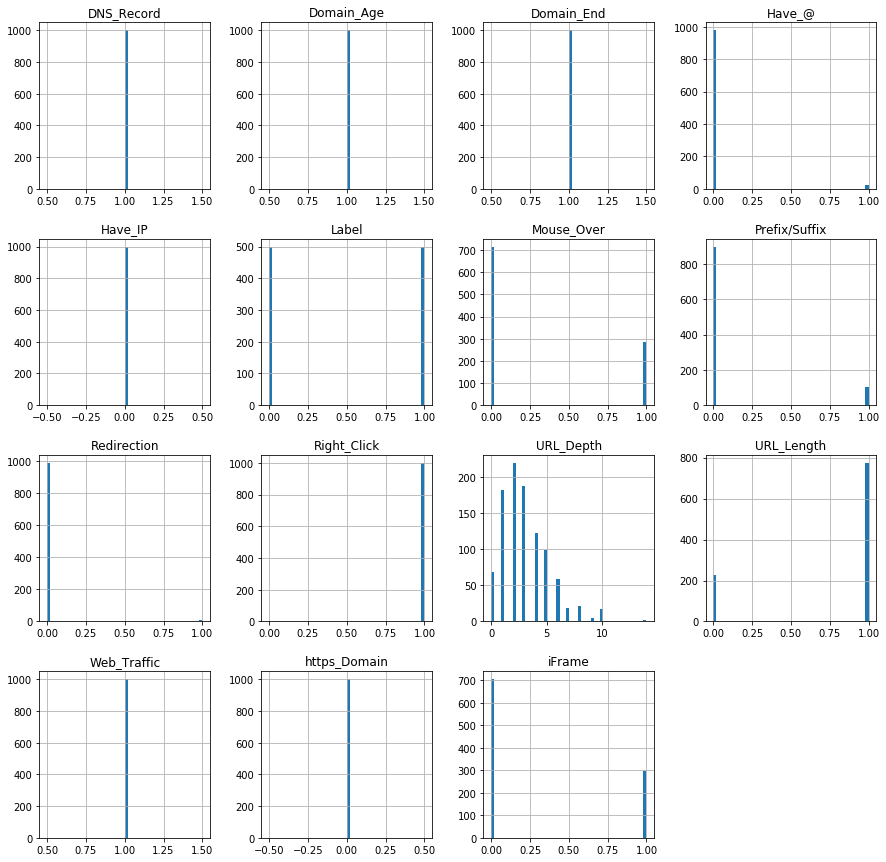

In [29]:
data0.hist(bins = 50,figsize = (15,15))
plt.show()

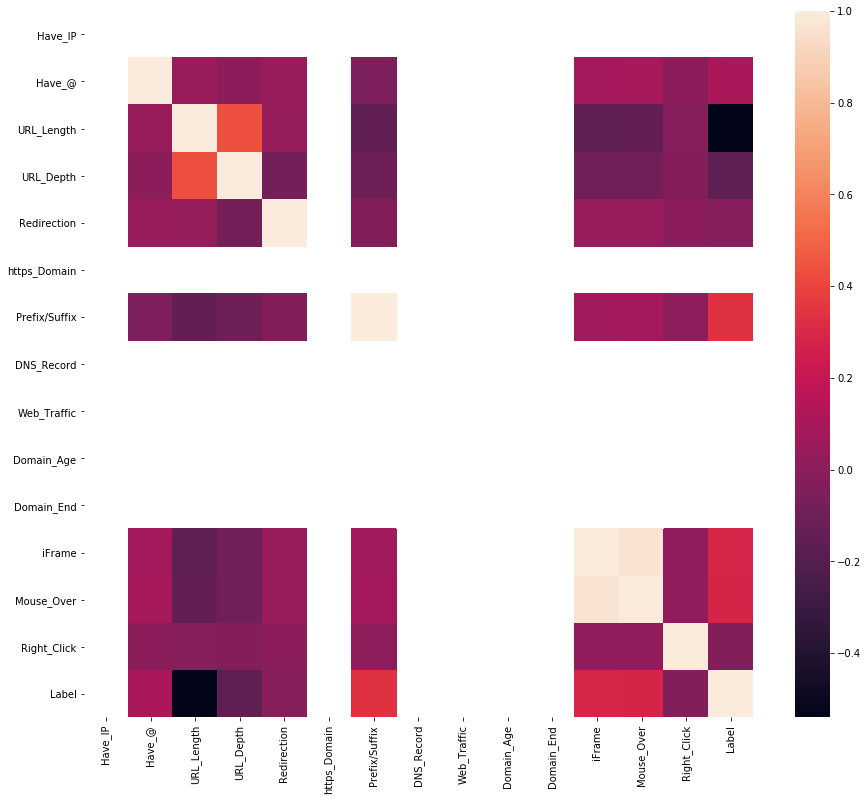

In [30]:

plt.figure(figsize=(15,13))
sns.heatmap(data0.corr())
plt.show()

## **4. Prepare Data:**

In [31]:
data0.describe()

,Have_IP,Have_@,URL_Length,URL_Depth,Redirection,https_Domain,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Label
count,1000.0,1000.000000,1000.000000,1000.000000,1000.00000,1000.0,1000.0000,1000.0,1000.0,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.0,0.021000,0.774000,3.056000,0.01200,0.0,0.1020,1.0,1.0,1.0,1.0,0.296000,0.284000,0.999000,0.50000
std,0.0,0.143456,0.418448,2.166462,0.10894,0.0,0.3028,0.0,0.0,0.0,0.0,0.456719,0.451162,0.031623,0.50025
min,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0000,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.00000
25%,0.0,0.000000,1.000000,1.000000,0.00000,0.0,0.0000,1.0,1.0,1.0,1.0,0.000000,0.000000,1.000000,0.00000
50%,0.0,0.000000,1.000000,3.000000,0.00000,0.0,0.0000,1.0,1.0,1.0,1.0,0.000000,0.000000,1.000000,0.50000
75%,0.0,0.000000,1.000000,4.000000,0.00000,0.0,0.0000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.00000
max,0.0,1.000000,1.000000,14.000000,1.00000,0.0,1.0000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.00000


In [33]:
data = data0.drop(['Domain'], axis = 1).copy()

In [34]:
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Have_IP,Have_@,URL_Length,URL_Depth,Redirection,https_Domain,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Label
0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1
1,0,0,1,5,0,0,0,1,1,1,1,0,0,1,1
2,0,0,1,3,0,0,0,1,1,1,1,0,0,1,0
3,0,0,1,2,0,0,0,1,1,1,1,0,0,1,1
4,0,0,1,6,0,0,0,1,1,1,1,0,0,1,0


In [35]:
y = data['Label']
X = data.drop('Label',axis=1)
X.shape, y.shape

((1000, 14), (1000,))

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

((800, 14), (200, 14))

## **5. ML training:**

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
ML_Model = []
acc_train = []
acc_test = []

#function to call for storing the results
def storeResults(model, a,b):
  ML_Model.append(model)
  acc_train.append(round(a, 3))
  acc_test.append(round(b, 3))

### **5.1. Decision Tree Classifier**

In [39]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth = 5)
# fit the model 
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [40]:
y_test_tree = tree.predict(X_test)
y_train_tree = tree.predict(X_train)

In [41]:
acc_train_tree = accuracy_score(y_train,y_train_tree)
acc_test_tree = accuracy_score(y_test,y_test_tree)

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))

Decision Tree: Accuracy on training Data: 0.825
Decision Tree: Accuracy on test Data: 0.860


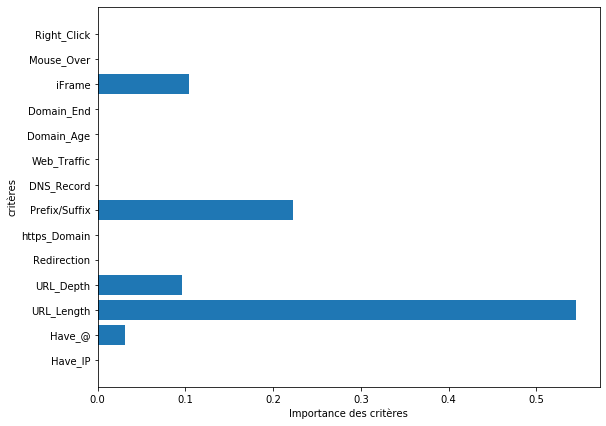

In [43]:
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Importance des critères")
plt.ylabel("critères")
plt.show()

In [44]:
storeResults('Decision Tree', acc_train_tree, acc_test_tree)

### **5.2. Random Forest Classifier**

In [45]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model 
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
y_test_forest = forest.predict(X_test)
y_train_forest = forest.predict(X_train)

In [48]:
acc_train_forest = accuracy_score(y_train,y_train_forest)
acc_test_forest = accuracy_score(y_test,y_test_forest)

print("Random forest: Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random forest: Accuracy on test Data: {:.3f}".format(acc_test_forest))

Random forest: Accuracy on training Data: 0.834
Random forest: Accuracy on test Data: 0.865


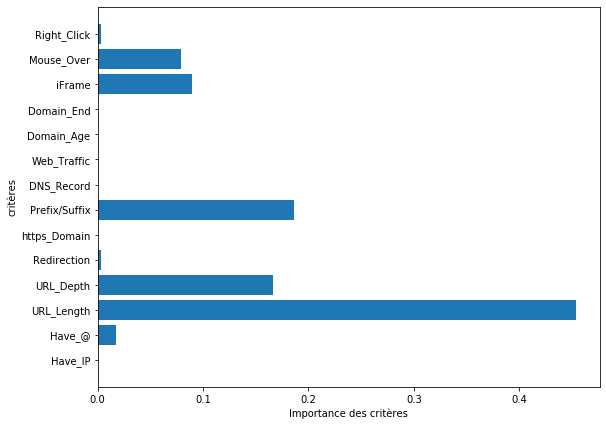

In [47]:
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Importance des critères")
plt.ylabel("critères")
plt.show()

In [49]:
storeResults('Random Forest', acc_train_forest, acc_test_forest)

### **5.3. Multilayer Perceptrons (MLPs)**

In [50]:
from sklearn.neural_network import MLPClassifier

# instantiate the model
mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=([100,100,100]))

# fit the model 
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[100, 100, 100], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [51]:
y_test_mlp = mlp.predict(X_test)
y_train_mlp = mlp.predict(X_train)

In [52]:
acc_train_mlp = accuracy_score(y_train,y_train_mlp)
acc_test_mlp = accuracy_score(y_test,y_test_mlp)

print("Multilayer Perceptrons: Accuracy on training Data: {:.3f}".format(acc_train_mlp))
print("Multilayer Perceptrons: Accuracy on test Data: {:.3f}".format(acc_test_mlp))

Multilayer Perceptrons: Accuracy on training Data: 0.834
Multilayer Perceptrons: Accuracy on test Data: 0.870


In [53]:
storeResults('Multilayer Perceptrons', acc_train_mlp, acc_test_mlp)

In [54]:
results = pd.DataFrame({ 'Modèles ML': ML_Model,    
    "Justesse d'entrainement": acc_train,
    "Justesse des tests": acc_test})
results

,Modèles ML,Justesse d'entrainement,Justesse des tests
0,Decision Tree,0.825,0.860
1,Random Forest,0.834,0.865
2,Multilayer Perceptrons,0.834,0.870


In [55]:
results.sort_values(by=["Justesse d'entrainement", "Justesse des tests"], ascending=False)

,Modèles ML,Justesse d'entrainement,Justesse des tests
2,Multilayer Perceptrons,0.834,0.870
1,Random Forest,0.834,0.865
0,Decision Tree,0.825,0.860
